# Created by Cmoon

In [1]:
import torch
from torch import nn
from cmoon_utils import *
import copy

In [2]:
class Trainer:
    def __init__(self):
        self.device=self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.log=TboardWriter('logs')
        self.train_iter, self.val_iter, self.test_iter = load_datasets(batch_size=20, train_ratio=0.7)
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.Linear(3 * 28 * 28, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(1024, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 36)).to(self.device)
        self.best=copy.deepcopy(self.net)
        self.batch_size = 20
        self.lr = 0.0001
        self.wc = 0.001
        self.epochs = 20
        self.loss = nn.CrossEntropyLoss().to(self.device)
        self.optim = torch.optim.Adam(self.net.parameters(), lr=self.lr, weight_decay=self.wc)
        self.scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(self.optim, 50)

    @timer
    def train_and_eval(self, epochs=None):
        print('Trained on GPU') if self.device == torch.device('cuda') else print('Trained on CPU')
        if epochs is None:
            epochs = self.epochs
        self.train(self.net, self.train_iter,self.val_iter, self.test_iter, self.loss, epochs, self.optim,self.scheduler)
        self.eval()
        

    def train_epoch(self, net, train_iter, loss, optim,scheduler):
        net.train()
        metric = Accumulator(3)
        for X, y in train_iter:
            X,y=try_gpu(X,y)
            y_hat = net(X)
            l = loss(y_hat, y)
            optim.zero_grad()
            l.backward()
            optim.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        scheduler.step()
        return metric[0] / metric[2], metric[1] / metric[2]

    def train(self, net, train_iter, val_iter,test_iter, loss, num_epochs, optim,scheduler):
        test_acc=0
        for epoch in range(num_epochs):
            train_metrics = self.train_epoch(net, train_iter, loss, optim,scheduler)
            val_acc = evaluate_accuracy(net, val_iter)
            last_acc = test_acc
            test_acc = evaluate_accuracy(net, test_iter)
            self.log.write_scalar('train_loss',train_metrics[0],epoch)
            self.log.write_scalar('train_acc',train_metrics[1],epoch)
            self.log.write_scalar('val_acc',val_acc,epoch)
            self.log.write_scalar('test_acc',test_acc,epoch)
            if (epoch+1)%5==0:
                print(f"Epoch:{epoch+1}, Train_loss:{train_metrics[0]}, Train_acc:{train_metrics[1]}")
            if test_acc>last_acc:
                self.best=copy.deepcopy(net)
        train_loss, train_acc = train_metrics
        self.log.close()
    
    def eval(self):
        self.best.eval()
        with torch.no_grad():
            for X, y in self.test_iter:
                X,y=try_gpu(X,y)
                y_hat = self.best(X)
                truth = idx2label(y)
                prediction = idx2label(y_hat.argmax(dim=1))
                print('Truth :{}\nPredic:{}'.format(truth, prediction))
                ploted = []
                for label, image in zip(prediction, X):
                    ploted.append(label)
                    self.log.write_image(label, image, ploted.count(label) - 1)
                plot_images(X.to('cpu').reshape(20, 3,28, 28), 2, 10, titles=prediction)
            accuracy=evaluate_accuracy(self.best, self.test_iter)
            print('Accuracy:{}'.format(accuracy))
        if accuracy == 1.0:
            print('识别错误的车牌字符: 无')
        else:
            false_labels = []
            for i in range(len(truth)):
                if truth[i] != prediction[i]:
                    false_labels.append(truth[i])
            print('识别错误的车牌字符: {}'.format(false_labels))
            


训练集:10024,验证集:4315,测试集:20
Trained on GPU
Epoch:5, Train_loss:0.13974570352896298, Train_acc:0.9732641660015962
Epoch:10, Train_loss:0.07595418149483496, Train_acc:0.9854349561053471
Epoch:15, Train_loss:0.055845480235531354, Train_acc:0.9887270550678372
Epoch:20, Train_loss:0.04425497807459036, Train_acc:0.9925179569034318
Epoch:25, Train_loss:0.03978550948625533, Train_acc:0.9917198723064645
Epoch:30, Train_loss:0.03488298806003968, Train_acc:0.9933160415003991
Epoch:35, Train_loss:0.02995624505709976, Train_acc:0.9953112529928172
Epoch:40, Train_loss:0.027471823868810377, Train_acc:0.9963088587390263
Epoch:45, Train_loss:0.025679718544992864, Train_acc:0.9965083798882681
Epoch:50, Train_loss:0.02542554375227594, Train_acc:0.99670790103751
Truth :['0', '8', '1', 'Z', '2', '7', '2', '6', '0', '6', 'jing', 'N', 'jing', 'B', 'V', 'P', 'P', 'Y', 'jing', '6']
Predic:['0', '8', '1', 'Z', '2', '7', '2', '6', '0', '6', 'jing', 'N', 'jing', 'B', 'V', 'P', 'P', 'Y', 'jing', '6']
Accuracy:1.0
识别

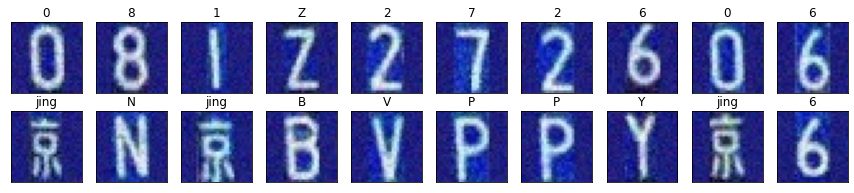

In [3]:
trainer=Trainer()
trainer.train_and_eval(epochs=50)